<a href="https://colab.research.google.com/github/Priyo-prog/Artificial-Intelligence-Projects/blob/main/Healthcare%20AI/healthcare_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare AI**

* AI is revolutionizing Healthcare in many areas such as :
  * Disease Diagonosis with medical imaging
  * Surgical Robots
  * Maximizing Hospital Efficiency

* Deep learning has been proven to be superior in detecting disease from X-rays, MRI scans and CT scans which could significantly improve the speed and accuracy of diagnosis.   

AIM :
* You have been tasked to improve the speed and accuracy of detecting and localizing brain tumors based on MRI scans.
* This would drastically reduce the cost of cancer diagnosis and help in early diagnosis of tumors which would essentially be a life saver.

* The team has collected brain MRI scans and approached you to develop a model that could detect and localize a tumor.

* You have been provided with 3929 brain MRI scans along with their brain tumor location.



**WHAT IS IMAGE SEGMENTATION ?**

* The goal of image segmentation is to understand and extract information from images at pixel-level.
* Image segmentation can be used for object recognition and localization which offers tremendous value in many applications such as medical imaging and self-driving cars etc.
* The goal of image segmentation is to train a neural network to produce pixel-wise mask of the image.
* Modern image segmentation techniques are based on deep learning approcah which makes use of common architectures such as CNN, FCNs(Fully Convolutional Networks) and Deep Encoders-Decoders.
* You will use ResUNet architecture to solve the current task.

## **Import Libraries and Packages**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files # library to upload files to colab notebook
%matplotlib inline

## **Mount Drive and Make Default Folder For Uploading Dataset**

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Navigate to My Drive directory to store dataset
%cd /content/drive/MyDrive/Artificial Intelligence Projects/Healthcare AI/Brain MRI

/content/drive/MyDrive/Artificial Intelligence Projects/Healthcare AI/Brain MRI


In [4]:
# data containing path to brain MRI and their corresponding mask
brain_df = pd.read_csv("data_mask.csv")

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(5)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


**MASK**

* The goal of image segmentation is to understand the image at pixel level. It associate each pixel with a certain class. The output produced by image segmentation model is called a "mask" of the image.

* Mask can be represented by associating pixel values with their coordinates. For example if we have a black image of shape (2,2) this can be represented as:

    [[0,0]

    [0,0]]

* If our output mask is as follows:

  [[255,0]

   [0,255]]

* To represent this mask we have to first flatten the image into a 1-D array. This would result in something like [255,0,0,255] for mask. Then we can use the index to create the mask. Finally we would have something like [1,0,0,1] as our mask.   

In [7]:
# Find whether the dataset is balanced or not
brain_df["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

## **Perform Data Visualization**

In [8]:
brain_df["mask"].value_counts().index

Int64Index([0, 1], dtype='int64')

In [9]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df["mask"].value_counts().index , y = brain_df["mask"].value_counts())])
fig.update_traces(marker_color = "rgb(0,200,0)", marker_line_color = "rgb(255,0,0)",
                        marker_line_width = 3, opacity = 0.6)
      
fig.show()      

In [10]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [11]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

In [12]:
img = cv2.imread(brain_df.mask_path[623])
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

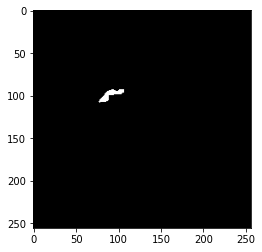

In [13]:
plt.imshow(img)

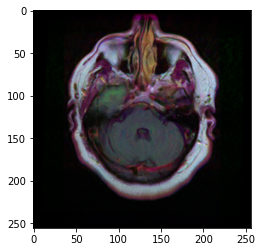

In [14]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

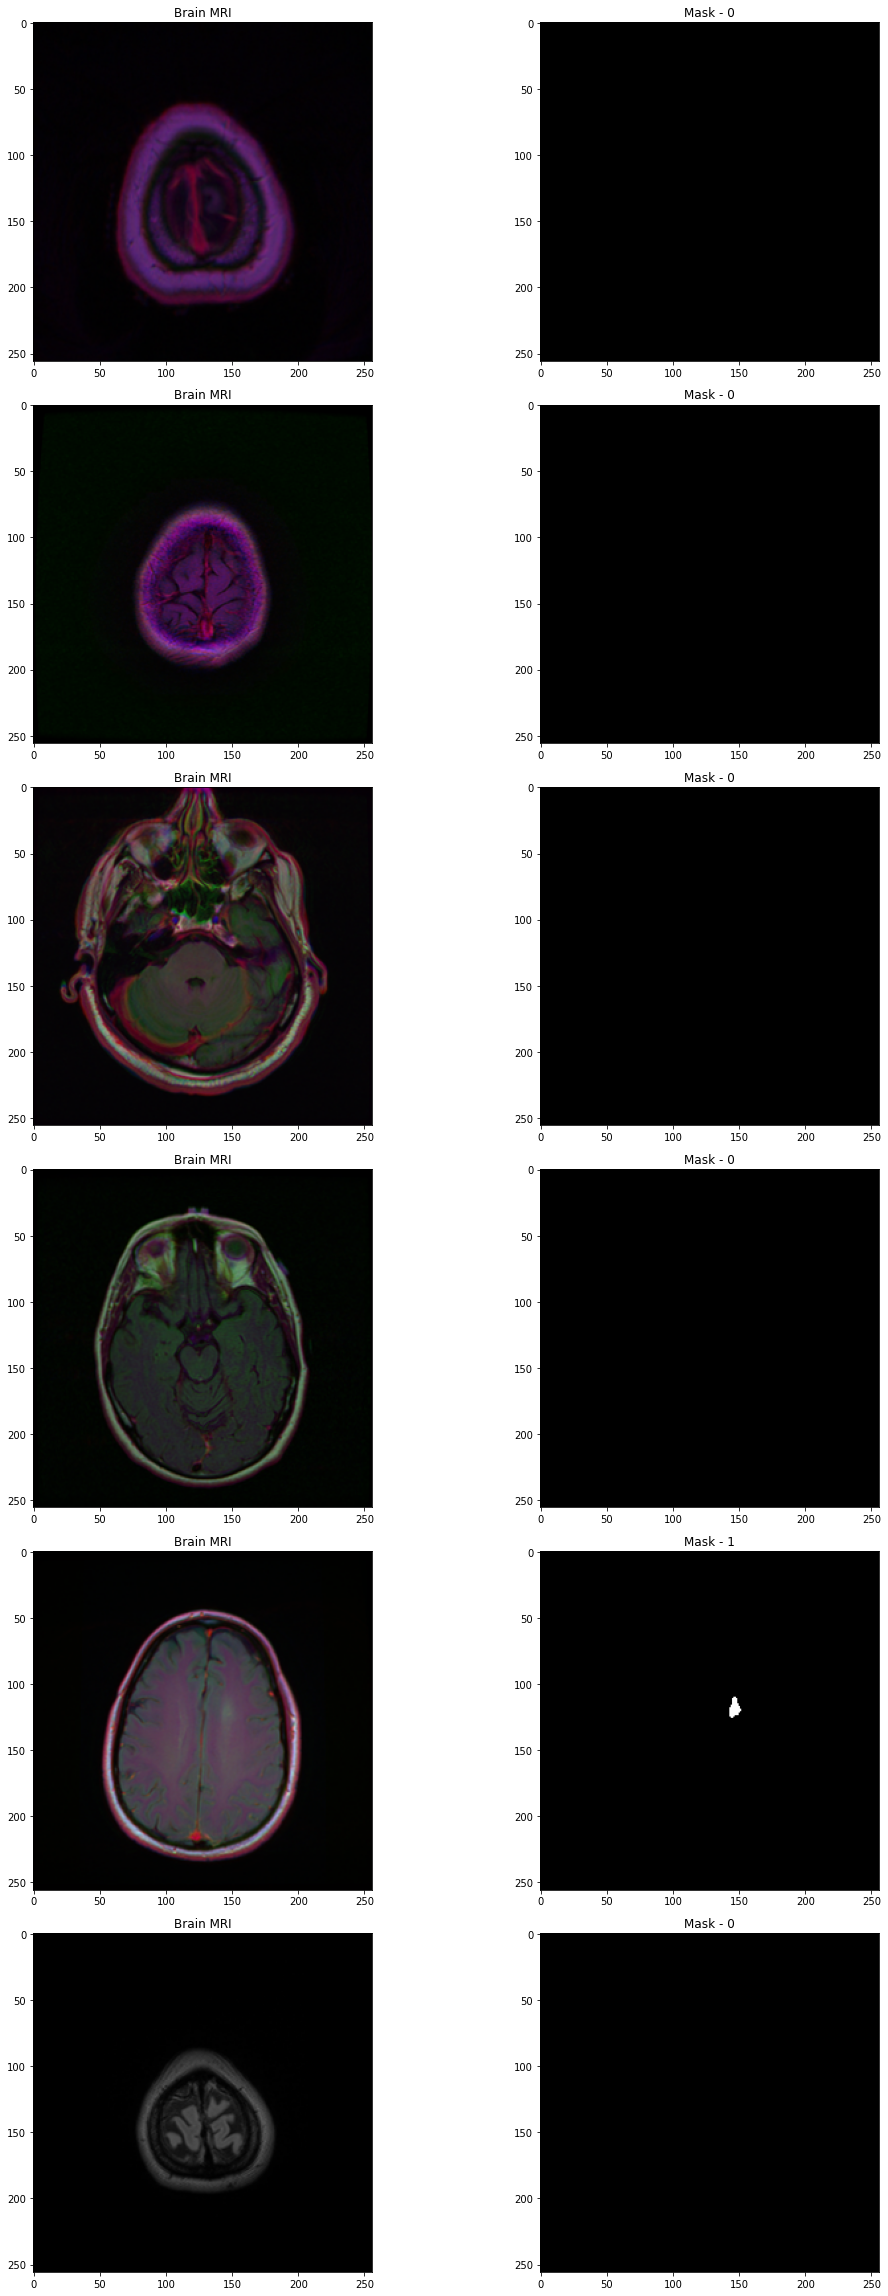

In [15]:
# Basic visualization: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - "+ str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # show corresponding mask
  count += 1

fig.tight_layout()

Plot 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the mask (in red color) on top of each other

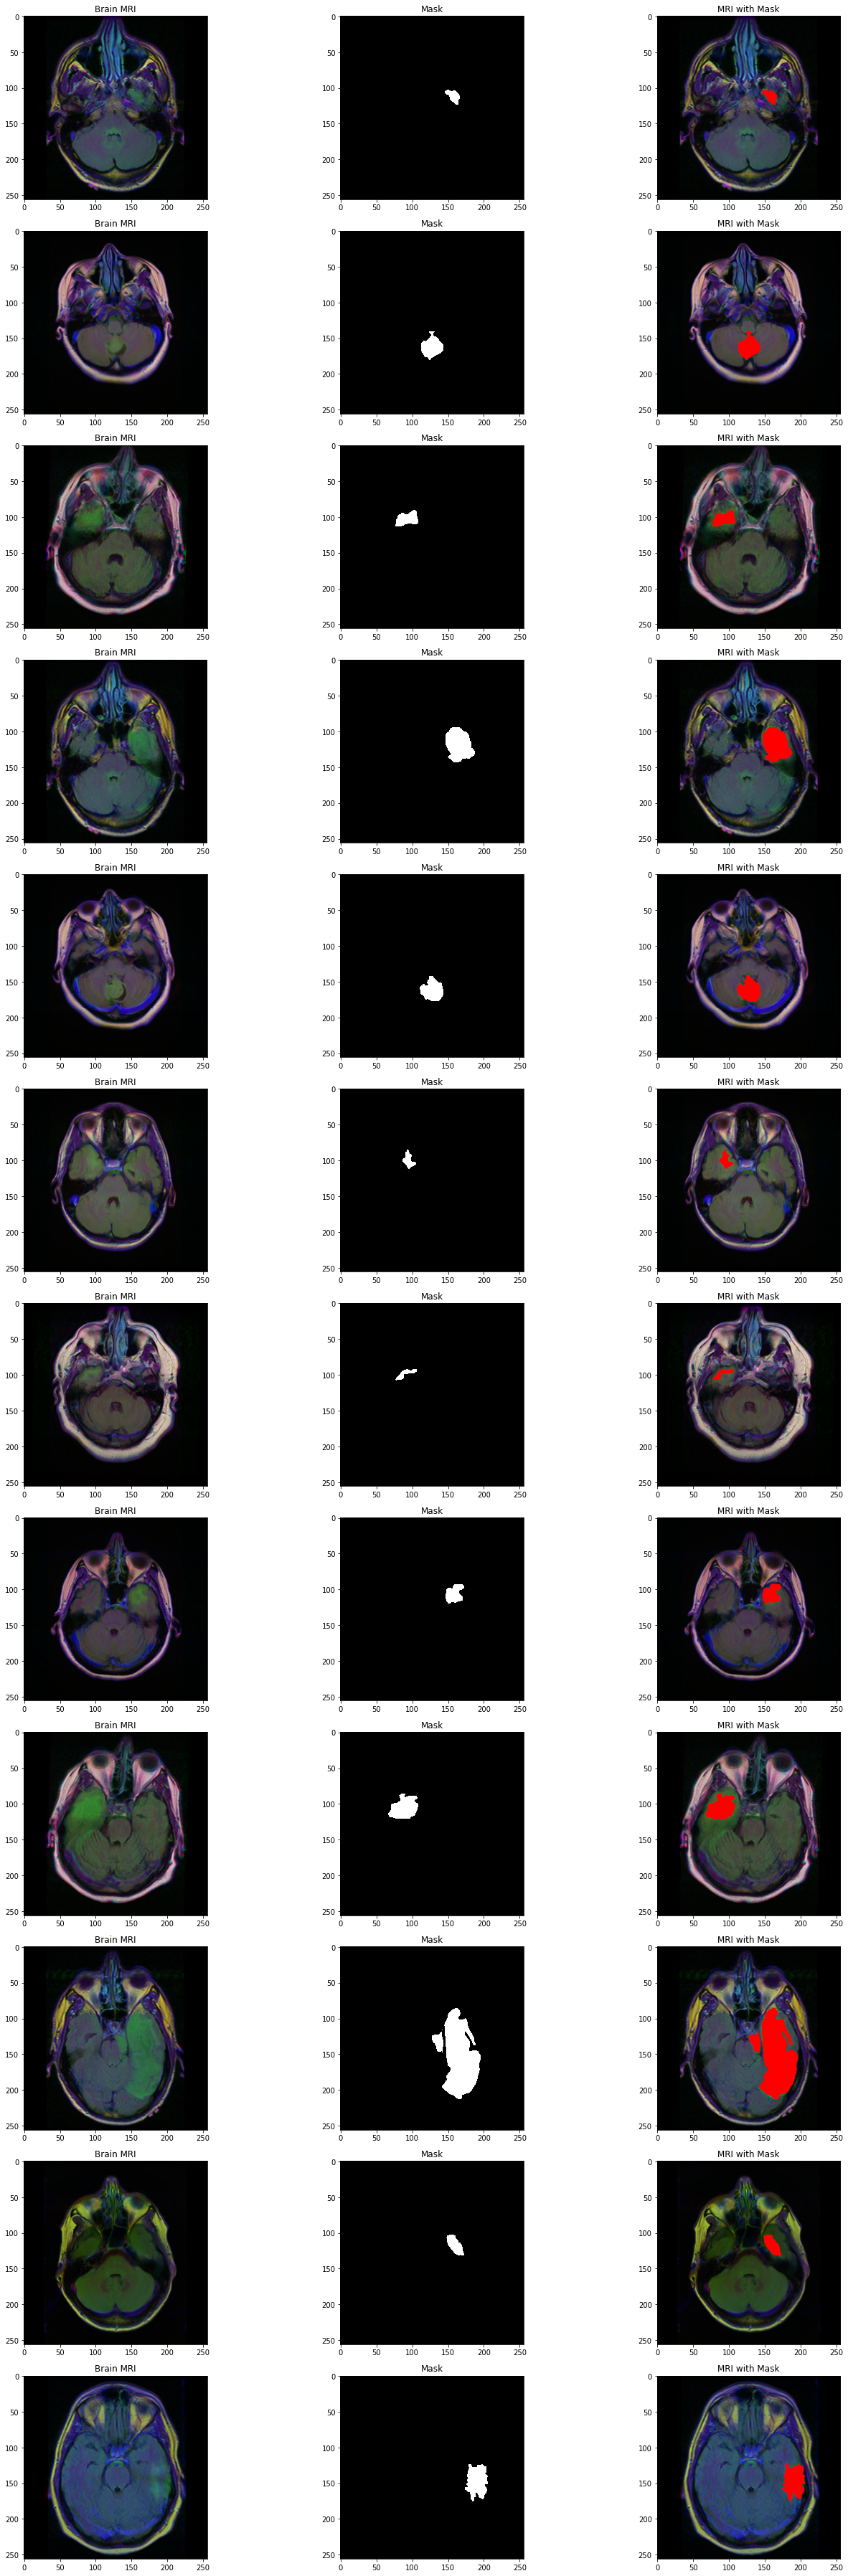

In [16]:
count = 0
fig, axs = plt.subplots(12, 3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap='gray')

    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()    

## **Training a Classifier Model to Detect Tumor**

In [17]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ["patient_id"])
brain_df_train.shape

(3929, 3)

Convert the data in mask column to string format, to use categorical mode in flow from dataframe.

You will get this error message if you comment out the following code line:

TypeError: If class_mode="categorical", y_col="mask" column values must be string, list or tuple.

In [18]:
brain_df_train["mask"] = brain_df_train["mask"].apply(lambda x: str(x))

In [19]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [20]:
# split the data into training and testing dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15)

In [21]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)

In [22]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory="./",
    x_col="image_path",
    y_col="mask",
    subset="training",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory="./",
    x_col="image_path",
    y_col="mask",
    subset="validation",
    batch_size=16,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256))

# create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="./",
    x_col="image_path",
    y_col="mask",
    batch_size=16,
    shuffle=False,
    class_mode="categorical",
    target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [23]:
# Get the Resnet50 base model
basemodel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
# Freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [26]:
# Add classification head to base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation="relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation="softmax")(headmodel)

model = Model(inputs = basemodel.input, outputs=headmodel)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [28]:
# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs.
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)

# save the model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 16, 
    epochs=1,
    validation_data=valid_generator,
    callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.9341 - accuracy: 0.7067 
Epoch 1: val_loss improved from inf to 0.63976, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2879s 16s/step - loss: 0.9341 - accuracy: 0.7067 - val_loss: 0.6398 - val_accuracy: 0.6640


In [31]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json", "w") as json_file:
  json_file.write(model_json)

## **Asses The Trained Model**

In [32]:
# Load pretrained model 
with open("resnet-50-MRI.json", "r") as json_file:
  json_savedModel = json_file.read()
#load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights("weights.hdf5")
model.compile(loss="categorical_entropy", optimizer="adam", metrics=["accuracy"])  

In [33]:
# make prediction
test_predict = model.predict(test_generator, steps=test_generator.n // 16, verbose=1)

36/36 [==============================] - 476s 14s/step


In [34]:
test_predict.shape

(576, 2)

In [35]:
test_predict

array([[1.6207469e-08, 1.0000000e+00],
       [1.0000000e+00, 2.0180031e-11],
       [9.9958926e-01, 4.1077650e-04],
       ...,
       [7.5552967e-12, 1.0000000e+00],
       [9.9999976e-01, 2.1507768e-07],
       [1.0000000e+00, 1.3812307e-08]], dtype=float32)

In [36]:
# Obtain the predict class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)  

In [37]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test["mask"])[:len(predict)]
len(original)

576

In [38]:
# obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9791666666666666

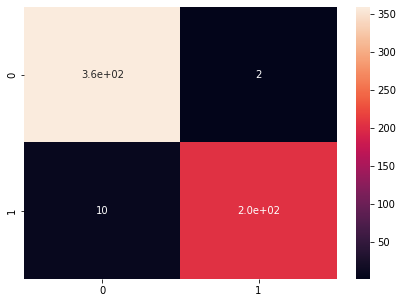

In [39]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)

Print out the classification report and comment on precision, recall and F1 score

In [40]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       361
           1       0.99      0.95      0.97       215

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.97      0.98       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## **RESUNET Architecture**

1. Encoder or contracting path consists of 4 blocks:

* First block consists of 3x3 convolutional layer + Relu + Batch Normalization.
* Remaining three blocks consists of Res-blocks followed by Max-Pooling 2x2.

2. Bottleneck :

* It is in between the contracting and expanding path.
* It consists of Res-block followed by up-sampling conv layer 2x2.

3. Expanding or decoder path consists of 4 blocks :

* 3 blocks following bottleneck consists of Res-blocks followed by up-sampling conv layer 2x2.
* Final block consists of Res-block followed by 1x1 conv layer.

## **Build a Segmentation Model to Localize Tumor**

In [41]:
# Get the dataframe containing MRIs which have masks associated with them
brain_df_mask = brain_df[brain_df["mask"] == 1]
brain_df_mask.shape 

(1373, 4)

In [42]:
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [43]:
# create the separate list for ImageId, classId to pass to the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)